# Board Retention Report Demo

This notebook demonstrates the core functionality of the board retention reporting system, showing how to:
- Generate retention reports across financial year quarters
- Create board-ready visualizations
- Analyze retention trends over time

**Financial Year Quarters:**
- Q1: July 1 to September 30
- Q2: October 1 to December 31
- Q3: January 1 to March 31
- Q4: April 1 to June 30

In [14]:
# Setup and imports
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import logging
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO)

# Import our modules
from src.retention_metrics.board_retention_reporter import (
    BoardRetentionReporter,
    FinancialYearCalculator,
    generate_annual_board_report,
    generate_quarterly_board_update
)
from src.retention_metrics.six_month_retention_processor import create_sample_retention_data
from src.visualization.board_report_visualizations import BoardReportVisualizer
from retentioneering.eventstream import Eventstream

print("✅ All imports successful")

✅ All imports successful


## 1. Create Sample Data and Eventstream

In [15]:
USE_SQL_DATA = True

if USE_SQL_DATA:
    # Load data from SQL database
    from src.data.extraction import DataExtractor
    extractor = DataExtractor()
    supporter_data = extractor.extract_supporter_actions(
        start_date='2023-01-01',
        end_date='2024-12-31',
        use_cache=True
    )

else:

    # Generate sample supporter data (2 years of data)
    supporter_data = create_sample_retention_data(n_supporters=800)

print(f"📊 Generated {len(supporter_data):,} supporter events")
print(f"👥 Covering {supporter_data['supporter_id'].nunique():,} unique supporters")
print(f"📅 Date range: {supporter_data['action_date'].min().date()} to {supporter_data['action_date'].max().date()}")

# Show sample of the data
display(supporter_data.head())

INFO:src.data.extraction:DataExtractor initialized
INFO:src.data.extraction:Loaded supporter actions from cache: actions_2023-01-01_2024-12-31_none_none


📊 Generated 630,628 supporter events
👥 Covering 347,613 unique supporters
📅 Date range: 2023-01-01 to 2024-12-30


,supporter_id,action_date,action_type,tags,supporter_level
0,1140218,2023-01-27 03:48:06,VOL,A-VOL_EOI-Z-Z-,1
1,1553597,2023-03-16 03:39:47,VOL,A-VOL_EOI-Z-Z-,1
2,1561805,2023-04-10 23:08:41,VOL,A-VOL_EOI-Z-Z-,1
3,1578338,2023-07-05 06:48:11,VOL,A-VOL_EOI-Z-Z-,1
4,1590656,2023-07-05 07:01:42,VOL,A-VOL_EOI-Z-Z-,1


In [16]:
# Create retentioneering eventstream
raw_data_schema = {
    'user_id': 'supporter_id',
    'event_name': 'action_type', 
    'event_timestamp': 'action_date'
}

eventstream = Eventstream(supporter_data, raw_data_schema=raw_data_schema)
print(f"✅ Created eventstream with {len(eventstream.to_dataframe())} events")

✅ Created eventstream with 1325854 events


## 2. Financial Year Quarter Calculations

Let's demonstrate how the financial year quarter logic works:

In [17]:
# Test financial year calculations
fy_calc = FinancialYearCalculator()

# Test different dates
test_dates = [
    date(2023, 8, 15),   # August - should be FY2024 Q1
    date(2023, 11, 20),  # November - should be FY2024 Q2  
    date(2024, 2, 10),   # February - should be FY2024 Q3
    date(2024, 5, 30),   # May - should be FY2024 Q4
]

print("🗓️  Financial Year Quarter Examples:")
print("=" * 50)

for test_date in test_dates:
    fy = fy_calc.get_financial_year(test_date)
    quarter = fy_calc.get_quarter_number(test_date)
    
    # Get full quarter info
    quarter_obj = fy_calc.create_financial_quarter(fy, quarter)
    
    print(f"{test_date} → {quarter_obj.label}")
    print(f"  Quarter dates: {quarter_obj.start_date} to {quarter_obj.end_date}")
    print()

🗓️  Financial Year Quarter Examples:
2023-08-15 → FY2024 Q1 (Jul 01 - Sep 30)
  Quarter dates: 2023-07-01 to 2023-09-30

2023-11-20 → FY2024 Q2 (Oct 01 - Dec 31)
  Quarter dates: 2023-10-01 to 2023-12-31

2024-02-10 → FY2024 Q3 (Jan 01 - Mar 31)
  Quarter dates: 2024-01-01 to 2024-03-31

2024-05-30 → FY2024 Q4 (Apr 01 - Jun 30)
  Quarter dates: 2024-04-01 to 2024-06-30



## 3. Generate Annual Board Report

Generate a comprehensive annual report for FY2024:

In [18]:
# Generate annual report for FY2024
annual_report = generate_annual_board_report(eventstream, 2024)

print("📈 Annual Board Report for FY2024")
print("=" * 50)

# Report metadata
metadata = annual_report['report_metadata']
print(f"Generated: {metadata['generated_at'].strftime('%Y-%m-%d %H:%M')}")
print(f"Date Range: {metadata['date_range']['start_date']} to {metadata['date_range']['end_date']}")
print(f"Quarters Analyzed: {metadata['quarters_analyzed']}")
print(f"Retention Periods: {metadata['retention_periods_calculated']}")
print()

INFO:src.retention_metrics.board_retention_reporter:Generating board retention report from 2023-07-01 to 2024-06-30
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 14.0% retention rate
INFO:src.retention_metrics.board_retention_reporter:Calculated retention for FY2024 Q1 → FY2024 Q2: 14.0%
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 9.6% retention rate
INFO:src.retention_metrics.board_retention_reporter:Calculated retention for FY2024 Q2 → FY2024 Q3: 9.6%
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 22.3% retention rate
INFO:src.retention_metrics.board_retention_reporter:C

📈 Annual Board Report for FY2024
Generated: 2025-07-14 15:41
Date Range: 2023-07-01 to 2024-06-30
Quarters Analyzed: 4
Retention Periods: 3



In [19]:
# Show quarters in the analysis
print("📅 Financial Quarters in Analysis:")
for i, quarter in enumerate(annual_report['quarters_in_range'], 1):
    print(f"{i}. {quarter['quarter']} ({quarter['start_date']} to {quarter['end_date']})")
print()

📅 Financial Quarters in Analysis:
1. FY2024 Q1 (Jul 01 - Sep 30) (2023-07-01 to 2023-09-30)
2. FY2024 Q2 (Oct 01 - Dec 31) (2023-10-01 to 2023-12-31)
3. FY2024 Q3 (Jan 01 - Mar 31) (2024-01-01 to 2024-03-31)
4. FY2024 Q4 (Apr 01 - Jun 30) (2024-04-01 to 2024-06-30)



In [20]:
# Show retention results
print("🎯 Retention Results by Period:")
print("=" * 80)

for period in annual_report['retention_periods']:
    print(f"{period['period_label']}:")
    print(f"  Retention Rate: {period['retention_rate']:.1f}%")
    print(f"  Supporters: {period['supporters_retained']:,}/{period['total_supporters_reference']:,} retained")
    print(f"  Not Retained: {period['supporters_not_retained']:,}")
    print()

🎯 Retention Results by Period:
FY2024 Q1 → FY2024 Q2:
  Retention Rate: 14.0%
  Supporters: 10,479/75,082 retained
  Not Retained: 64,603

FY2024 Q2 → FY2024 Q3:
  Retention Rate: 9.6%
  Supporters: 12,560/130,569 retained
  Not Retained: 118,009

FY2024 Q3 → FY2024 Q4:
  Retention Rate: 22.3%
  Supporters: 13,078/58,649 retained
  Not Retained: 45,571



In [21]:
# Show summary statistics
stats = annual_report['summary_statistics']

print("📊 Summary Statistics:")
print("=" * 30)
print(f"Average Retention Rate: {stats['average_retention_rate']:.1f}%")
print(f"Median Retention Rate: {stats['median_retention_rate']:.1f}%")
print(f"Range: {stats['min_retention_rate']:.1f}% - {stats['max_retention_rate']:.1f}%")
print(f"Standard Deviation: {stats['std_retention_rate']:.1f}%")
print(f"Trend: {stats['retention_rate_trend'].upper()}")
print(f"Total Supporters Analyzed: {stats['total_supporters_across_periods']:,}")
print(f"Average per Period: {stats['average_supporters_per_period']:.0f}")

📊 Summary Statistics:
Average Retention Rate: 15.3%
Median Retention Rate: 14.0%
Range: 9.6% - 22.3%
Standard Deviation: 5.3%
Trend: IMPROVING
Total Supporters Analyzed: 264,300
Average per Period: 88100


## 4. Generate Custom Date Range Report

Show how to analyze a custom date range:

In [22]:
# Custom date range report (last 18 months)
reporter = BoardRetentionReporter(eventstream)

# Define custom period
end_date = date(2024, 6, 30)
start_date = date(2023, 1, 1)

custom_report = reporter.generate_board_report(
    start_date=start_date,
    end_date=end_date,
    include_partial_quarters=True
)

print(f"📊 Custom Report: {start_date} to {end_date}")
print("=" * 50)
print(f"Periods analyzed: {len(custom_report['retention_periods'])}")

# Show just the retention rates
for period in custom_report['retention_periods']:
    print(f"{period['reference_quarter']} → {period['following_quarter']}: {period['retention_rate']:.1f}%")

INFO:src.retention_metrics.board_retention_reporter:Generating board retention report from 2023-01-01 to 2024-06-30
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 15.8% retention rate
INFO:src.retention_metrics.board_retention_reporter:Calculated retention for FY2023 Q3 → FY2023 Q4: 15.8%
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 15.9% retention rate
INFO:src.retention_metrics.board_retention_reporter:Calculated retention for FY2023 Q4 → FY2024 Q1: 15.9%
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 14.0% retention rate
INFO:src.retention_metrics.board_retention_reporter

📊 Custom Report: 2023-01-01 to 2024-06-30
Periods analyzed: 5
FY2023 Q3 (Jan 01 - Mar 31) → FY2023 Q4 (Apr 01 - Jun 30): 15.8%
FY2023 Q4 (Apr 01 - Jun 30) → FY2024 Q1 (Jul 01 - Sep 30): 15.9%
FY2024 Q1 (Jul 01 - Sep 30) → FY2024 Q2 (Oct 01 - Dec 31): 14.0%
FY2024 Q2 (Oct 01 - Dec 31) → FY2024 Q3 (Jan 01 - Mar 31): 9.6%
FY2024 Q3 (Jan 01 - Mar 31) → FY2024 Q4 (Apr 01 - Jun 30): 22.3%


## 5. Create Board Visualizations

Generate professional charts for board presentations:

📈 Creating Retention Trend Chart...


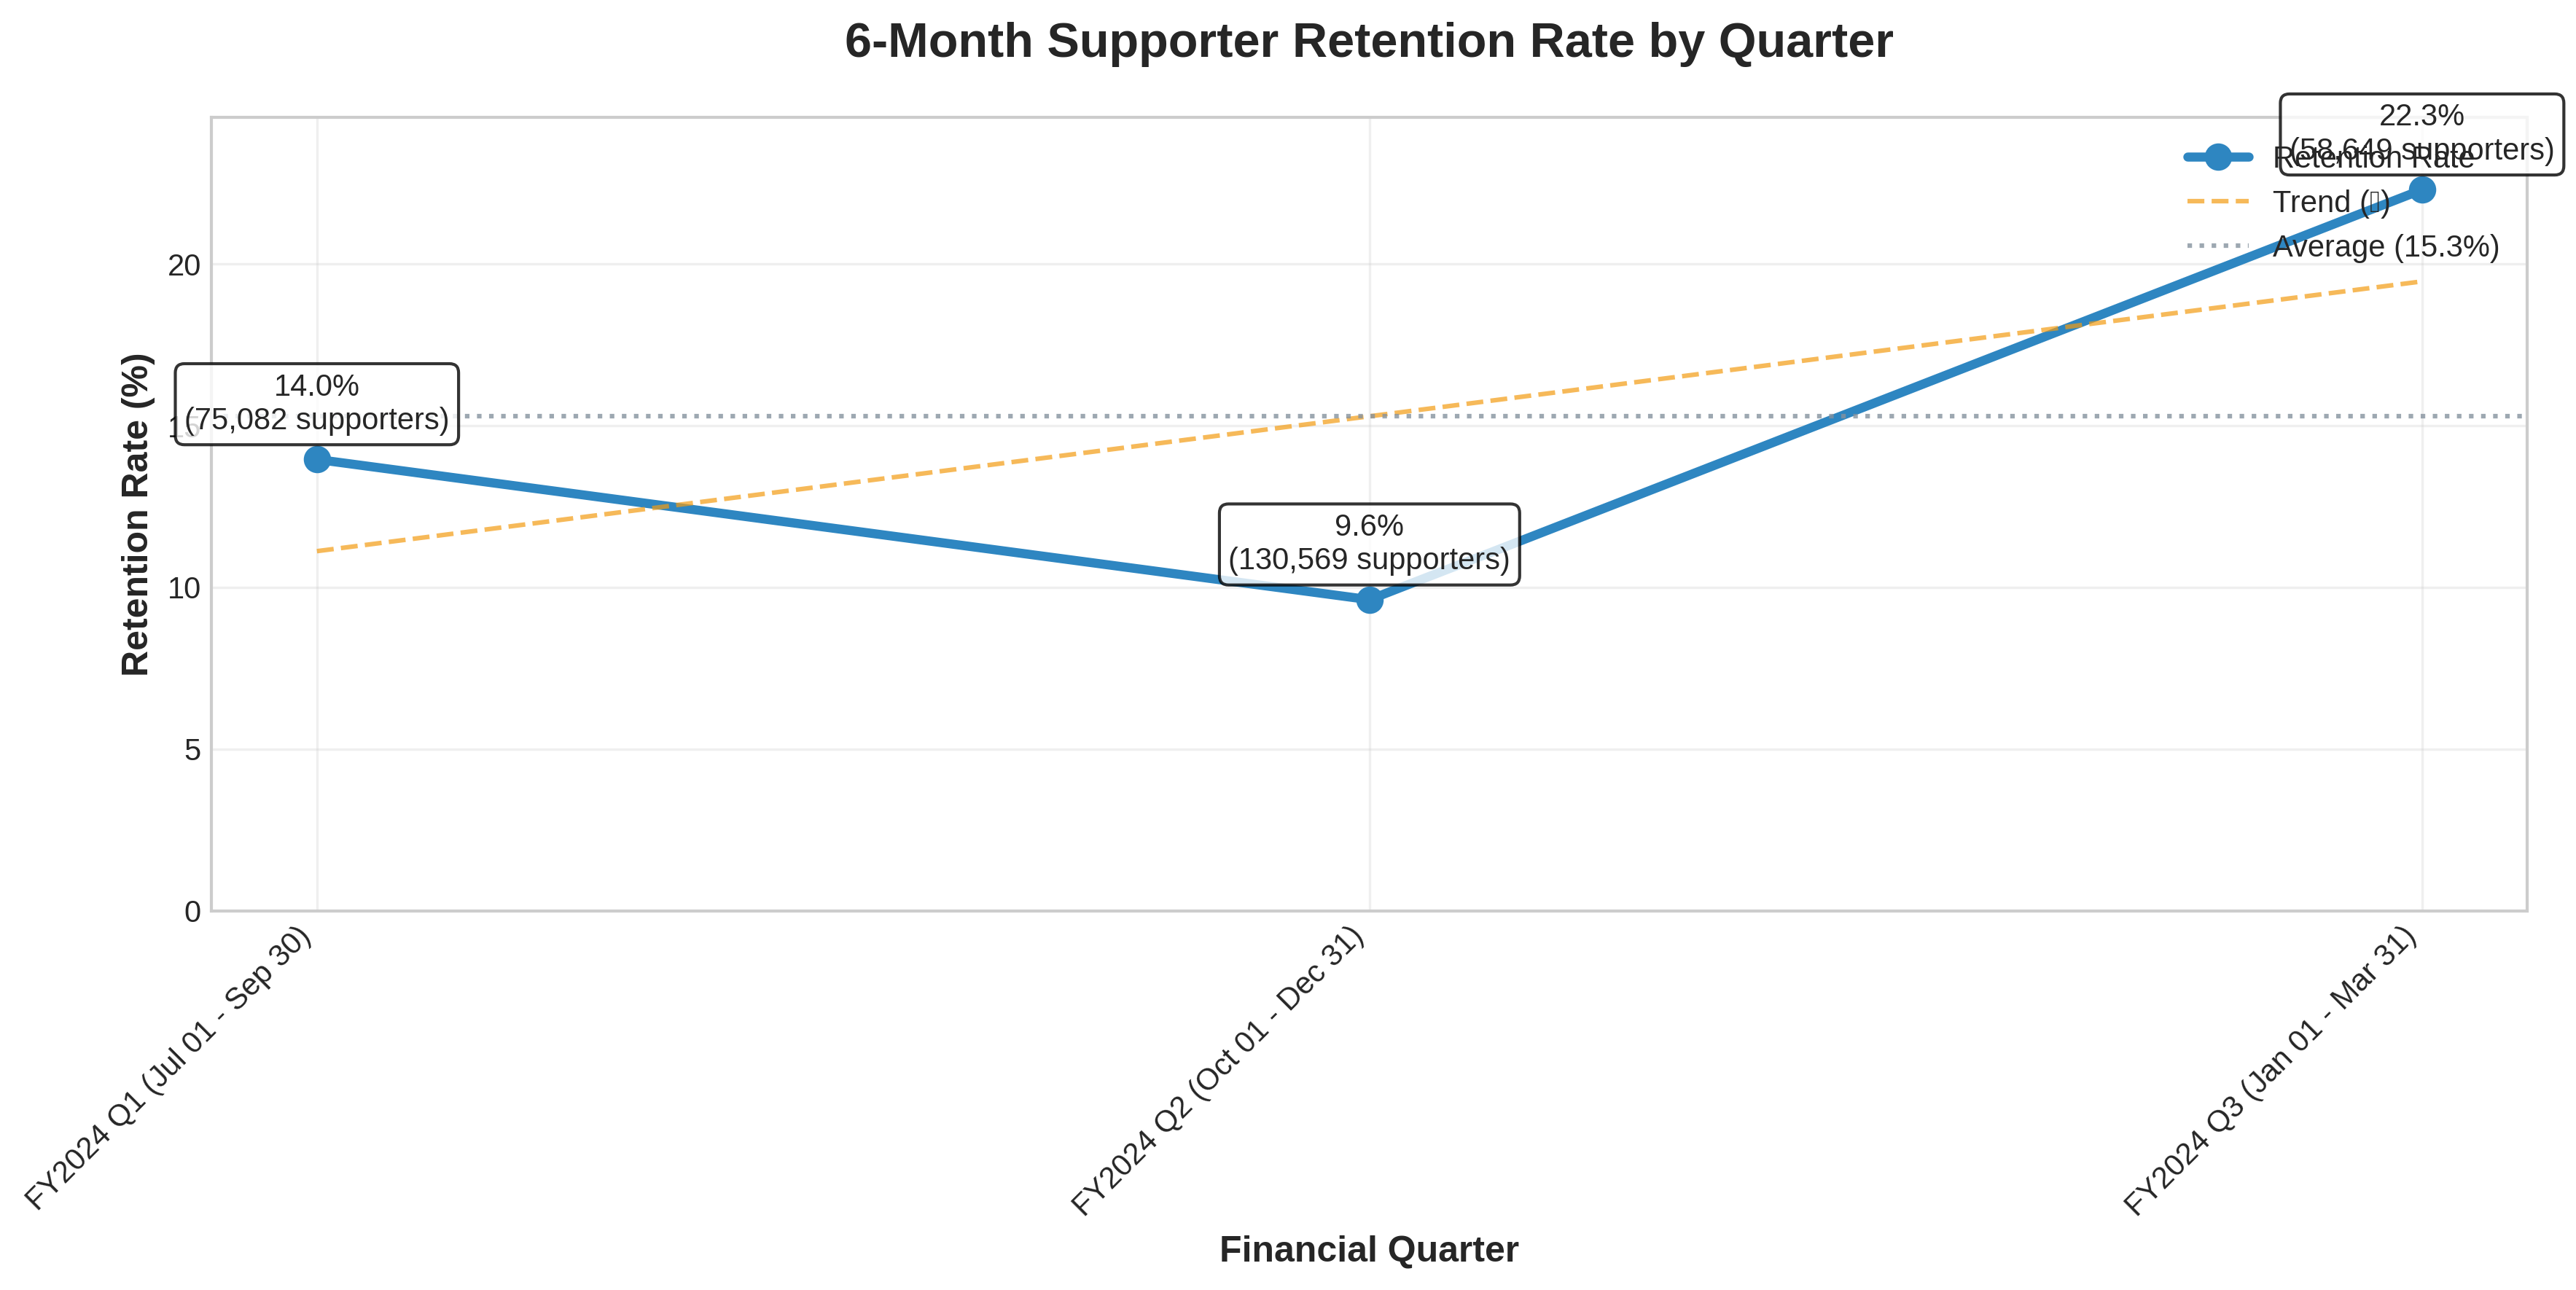

In [23]:
# Create visualizer
visualizer = BoardReportVisualizer(figsize=(12, 6))

# 1. Retention trend chart
print("📈 Creating Retention Trend Chart...")
fig1 = visualizer.create_retention_trend_chart(annual_report, show_chart=True)
plt.show()

👥 Creating Supporter Volume Chart...


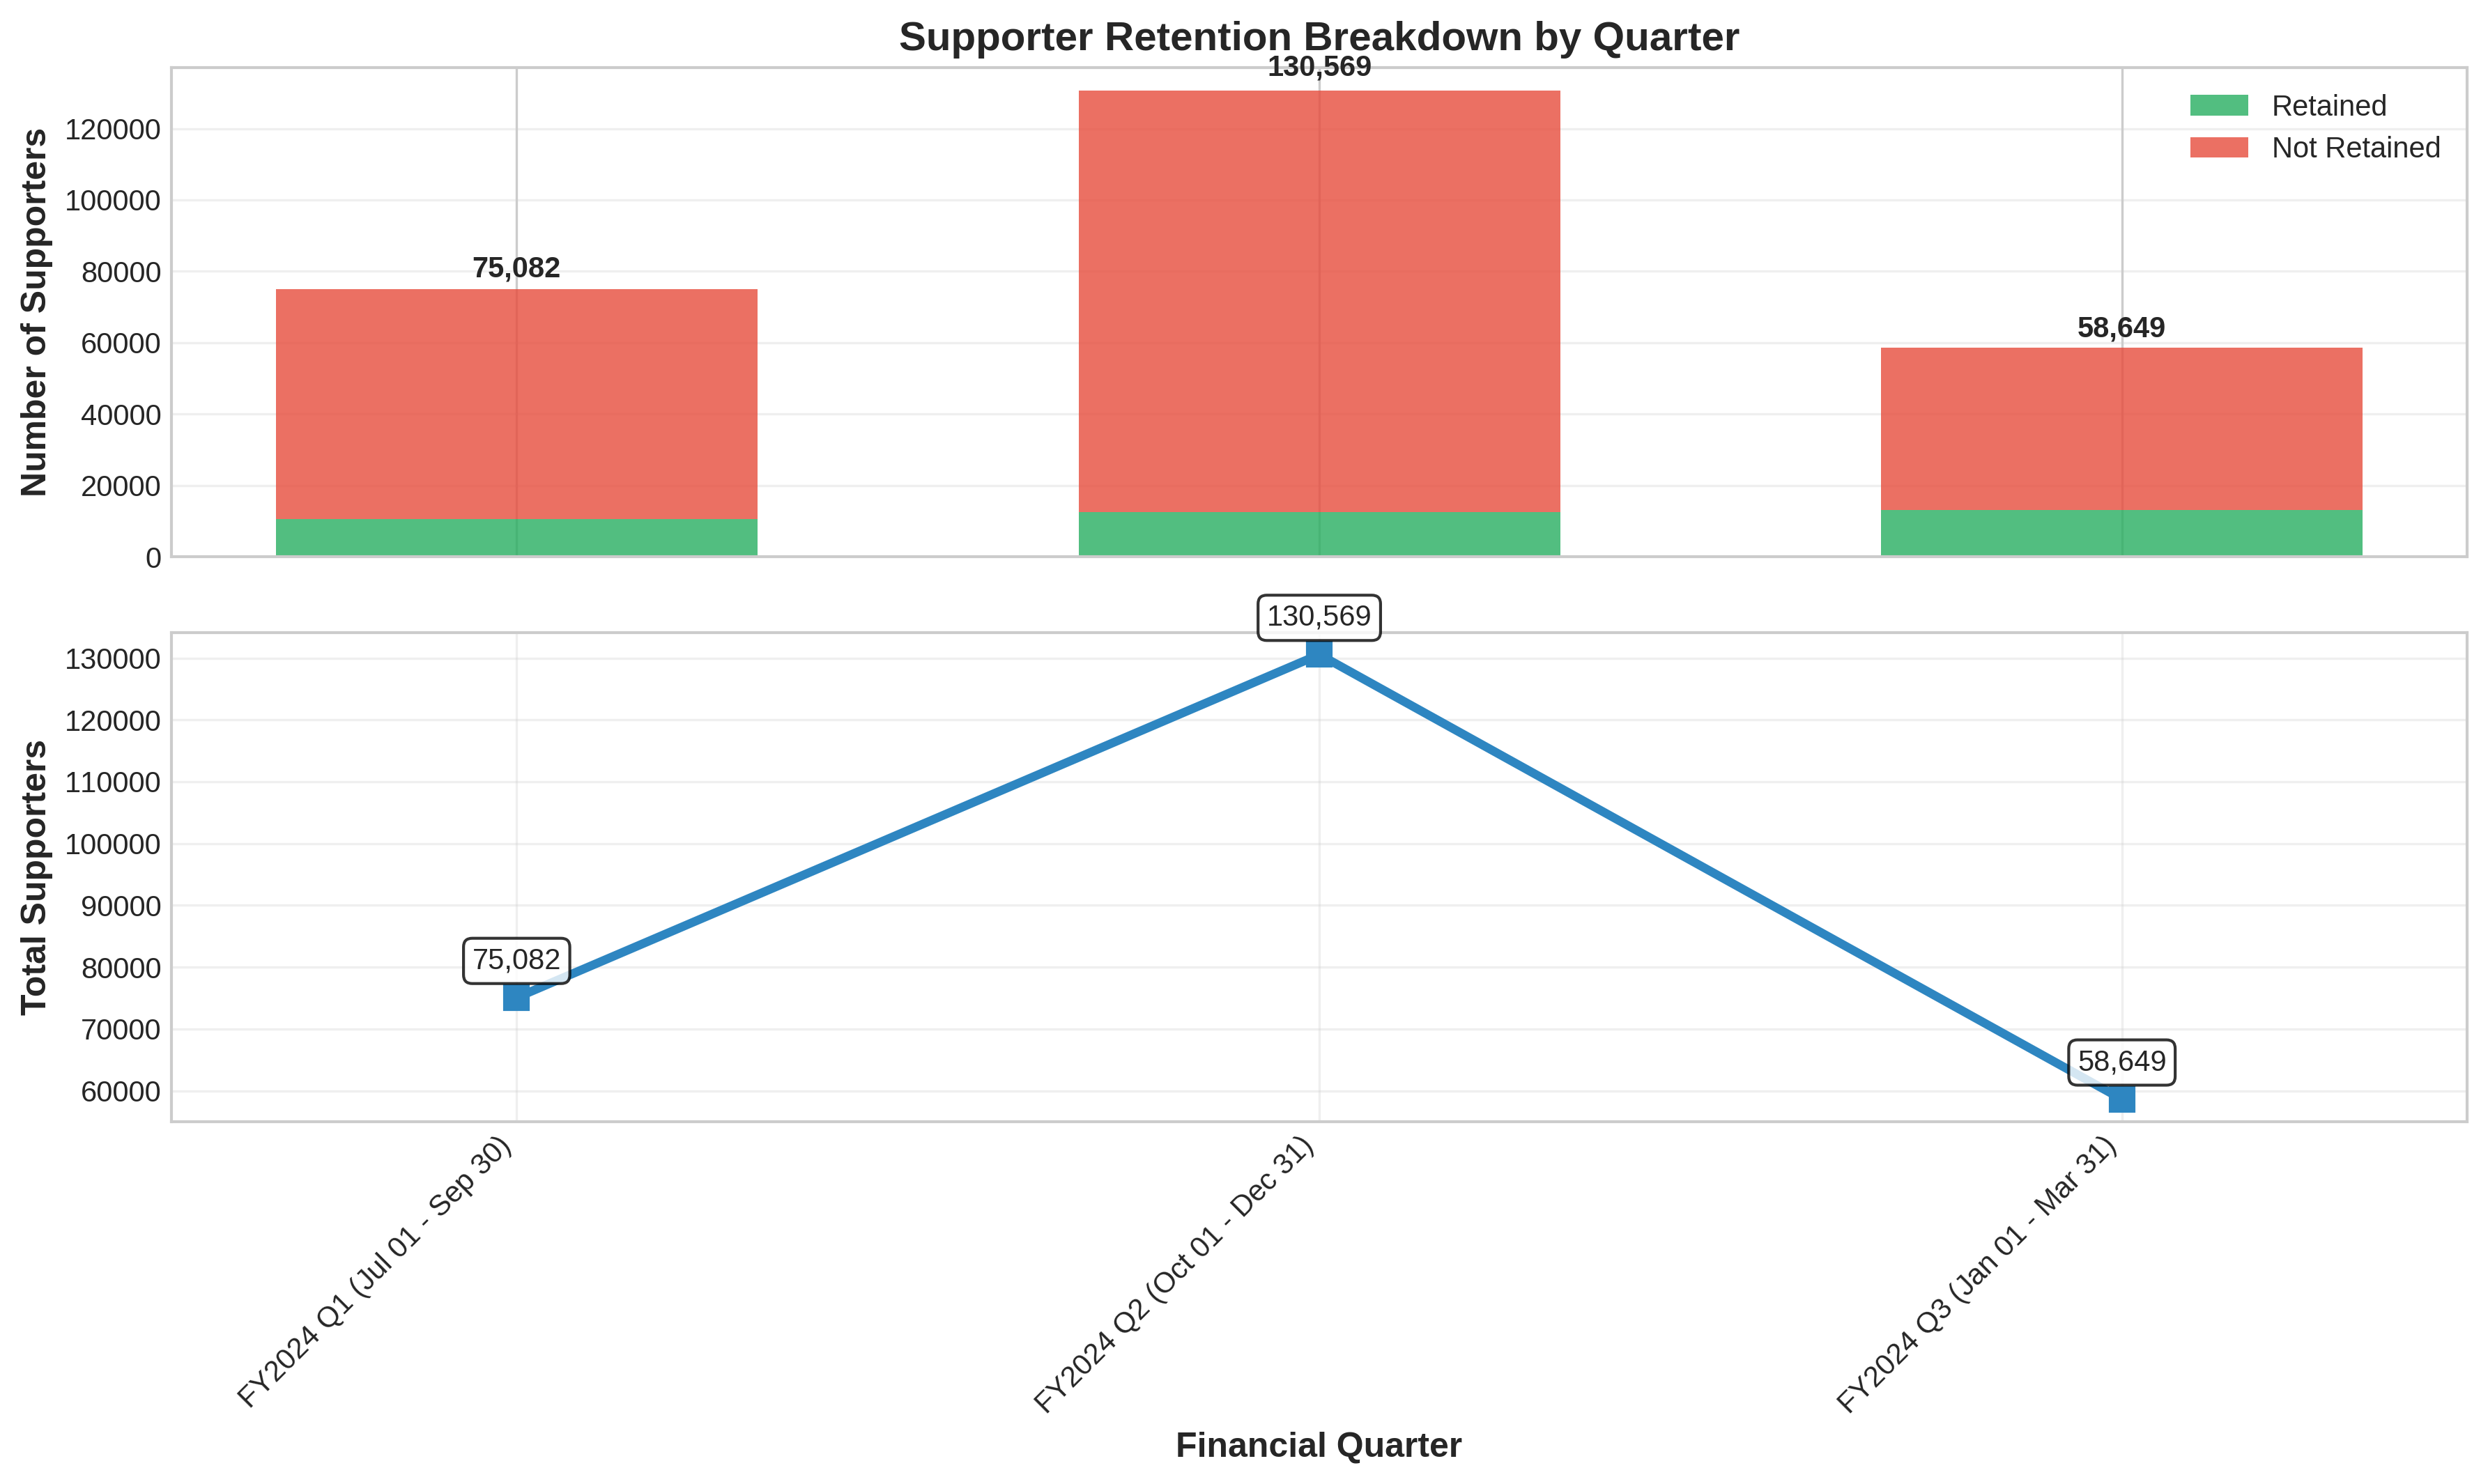

In [24]:
# 2. Supporter volume analysis
print("👥 Creating Supporter Volume Chart...")
fig2 = visualizer.create_supporter_volume_chart(annual_report, show_chart=True)
plt.show()

📊 Creating Executive Dashboard...


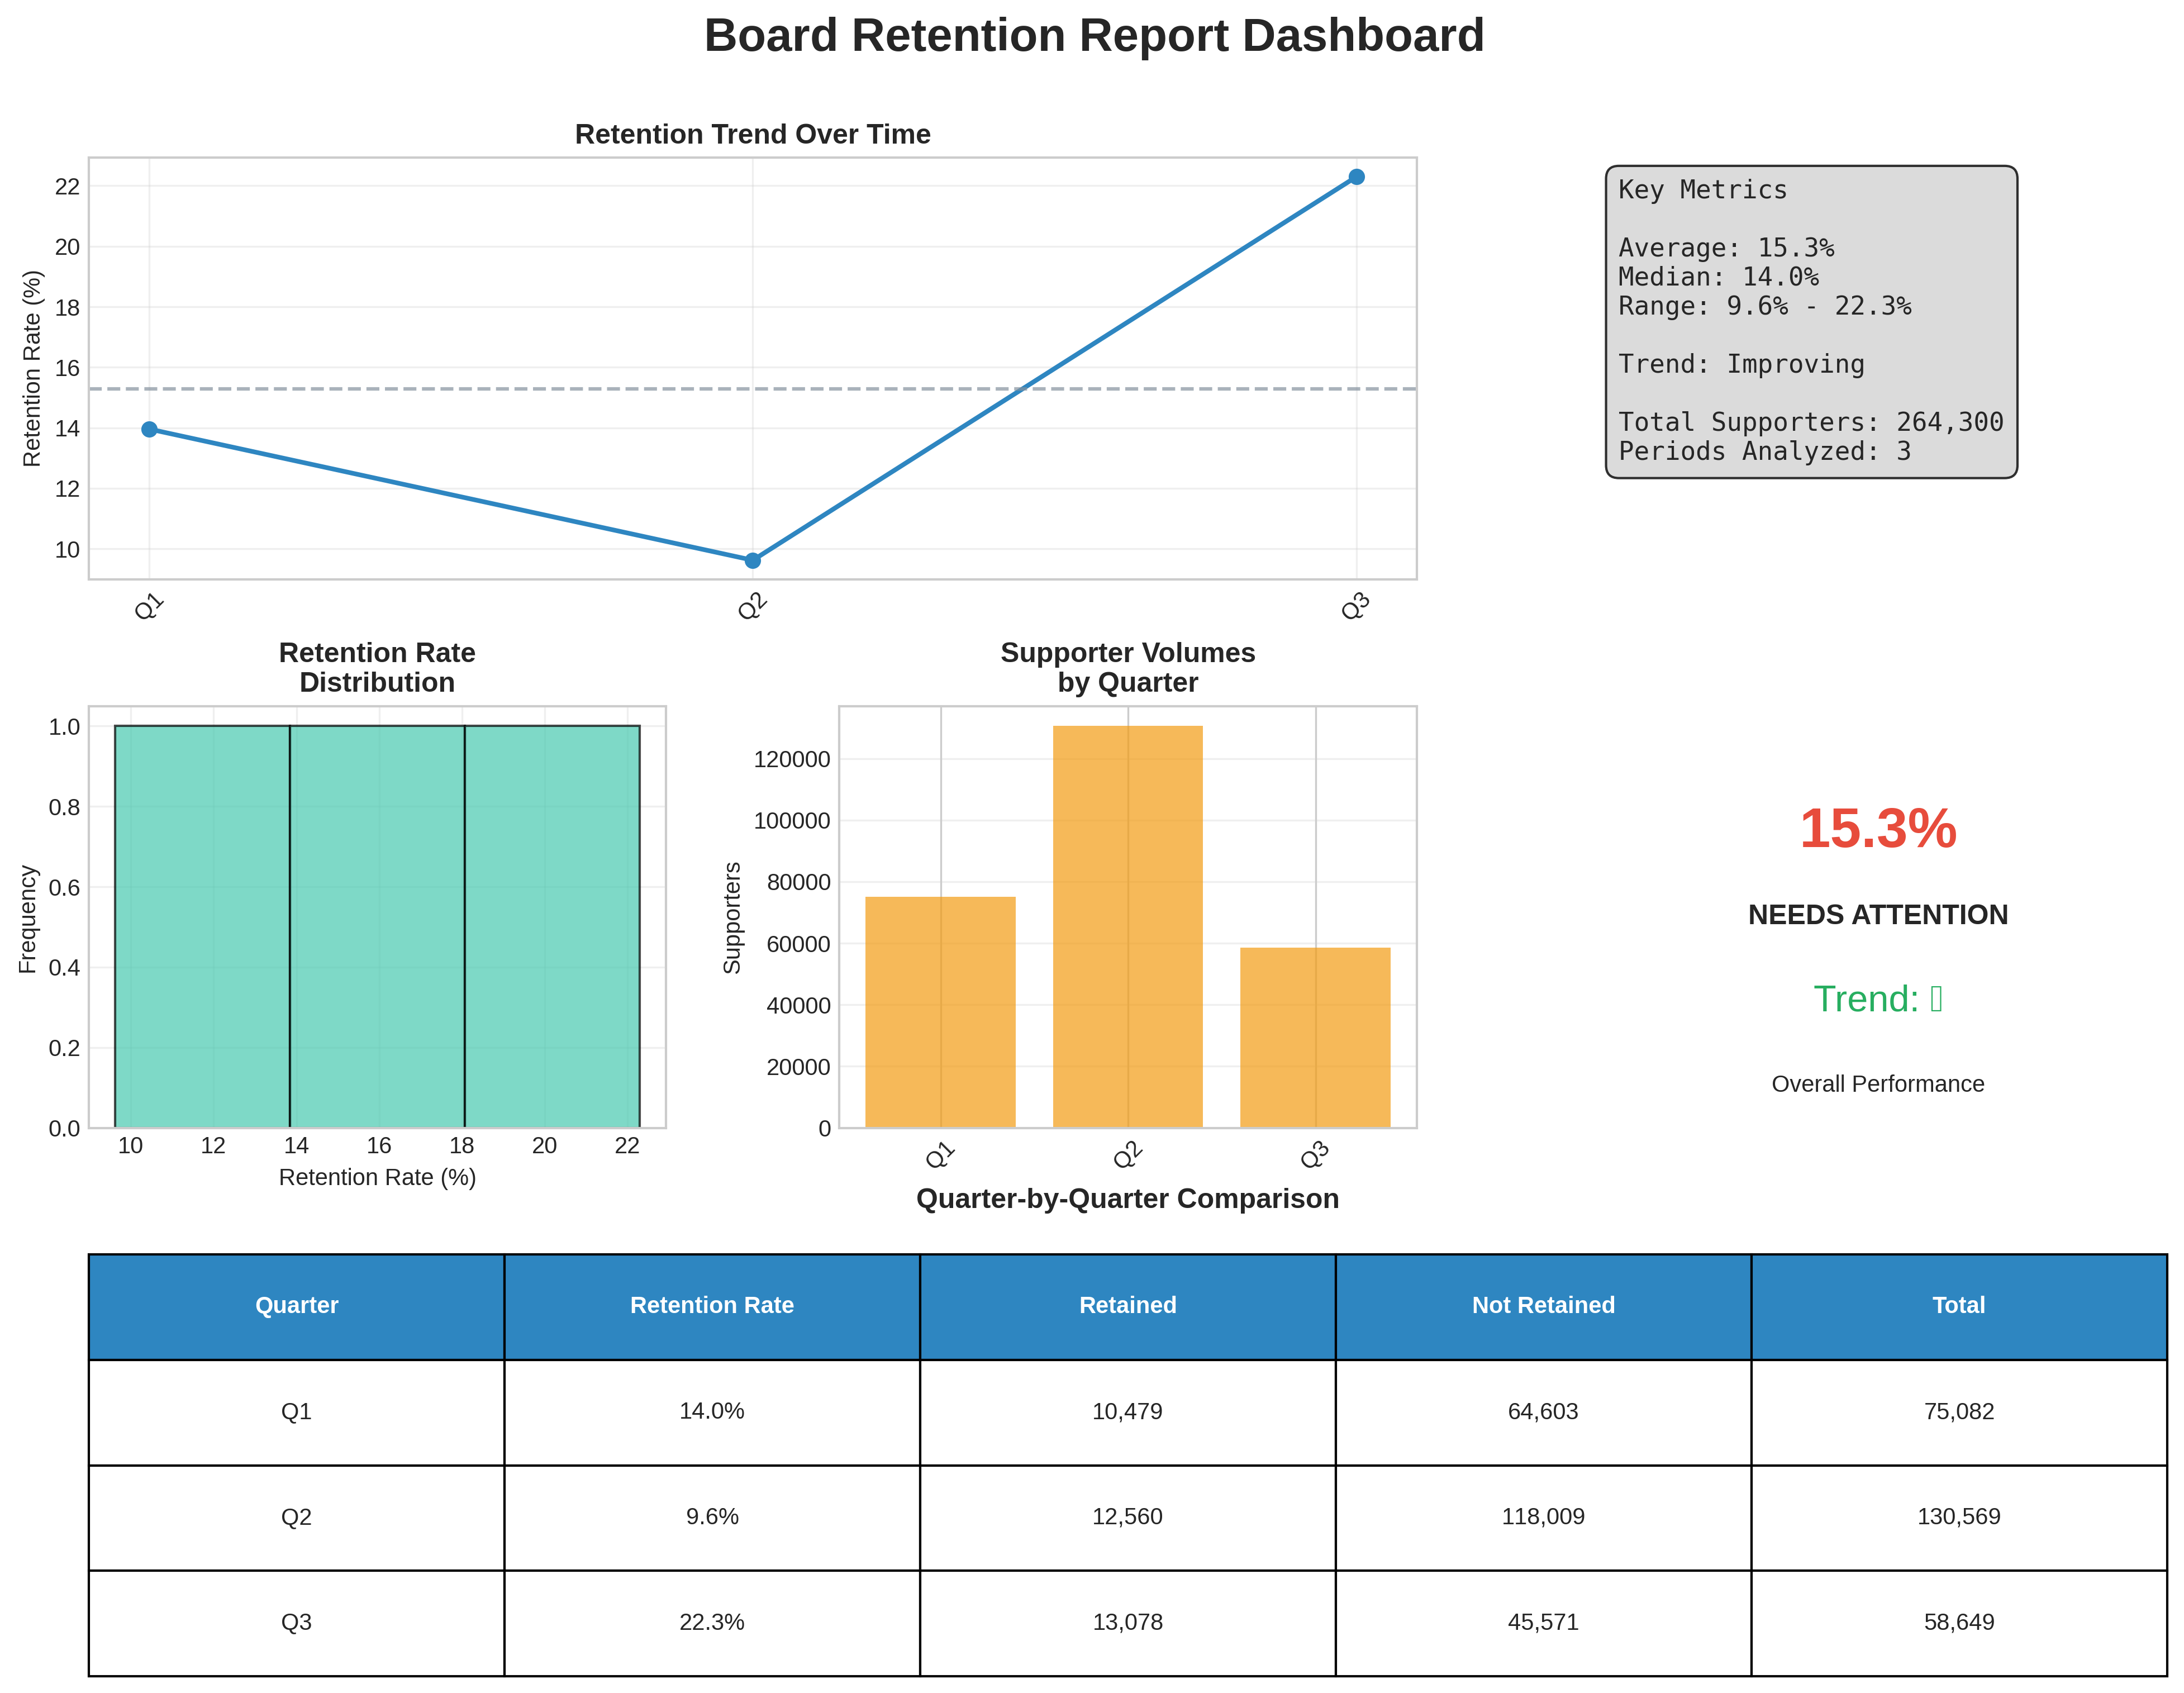

In [25]:
# 3. Executive dashboard
print("📊 Creating Executive Dashboard...")
fig3 = visualizer.create_summary_dashboard(annual_report, show_chart=True)
plt.show()

## 6. Quick Analysis Functions

Demonstrate some useful analysis helpers:

In [ ]:
# Generate quarterly board update (recent quarters)
quarterly_update = generate_quarterly_board_update(eventstream)

print("📋 Quarterly Board Update:")
print("=" * 40)

if quarterly_update['retention_periods']:
    latest_period = quarterly_update['retention_periods'][-1]
    print(f"Latest Period: {latest_period['period_label']}")
    print(f"Retention Rate: {latest_period['retention_rate']:.1f}%")
    print(f"Supporters: {latest_period['total_supporters_reference']:,}")
    
    # Compare to previous period if available
    if len(quarterly_update['retention_periods']) > 1:
        prev_period = quarterly_update['retention_periods'][-2]
        change = latest_period['retention_rate'] - prev_period['retention_rate']
        direction = "📈" if change > 0 else "📉" if change < 0 else "➡️"
        print(f"Change from previous: {direction} {change:+.1f} percentage points")
else:
    print("No retention periods available for quarterly update")

INFO:src.retention_metrics.board_retention_reporter:Generating board retention report from 2025-01-01 to 2025-07-14
INFO:src.retention_metrics.six_month_retention_processor:Starting 6-month retention calculation
INFO:src.retention_metrics.six_month_retention_processor:Retention calculation completed: 0.0% retention rate
INFO:src.retention_metrics.board_retention_reporter:Calculated retention for FY2025 Q3 → FY2025 Q4: 0.0%
INFO:src.retention_metrics.board_retention_reporter:Board report generated successfully with 1 retention periods


📋 Quarterly Board Update:
Latest Period: FY2025 Q3 → FY2025 Q4
Retention Rate: 0.0%
Supporters: 0


## Summary

This notebook demonstrated:

✅ **Financial Year Quarter Logic**: Proper handling of FY quarters (Q1: Jul-Sep, Q2: Oct-Dec, etc.)  
✅ **Annual Reporting**: Generate comprehensive FY reports with multiple retention periods  
✅ **Custom Date Ranges**: Analyze any arbitrary date range with quarter breakdowns  
✅ **Board Visualizations**: Professional charts ready for board presentations  
✅ **Summary Statistics**: Trends, averages, and performance indicators  

The system seamlessly integrates with your existing `SixMonthRetentionProcessor` while adding the financial quarter intelligence needed for board reporting.

**Next Steps:**
- Replace sample data with your actual Azure SQL Database connection
- Customize visualizations for your organization's branding
- Set up automated quarterly reporting workflows
- Add additional metrics as needed for your board requirements